**Pareja 6**

**Daniel Mohedano**

**Silvia Sopeña**

In [1]:
from Datos import Datos
from clasificador import ClasificadorKNN, ClasificadorRegresionLogistica, ClasificadorNaiveBayes
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada
import numpy as np
import pandas as pd

# Apartado 1

In [2]:
datos_pima = Datos('data/pima-indians-diabetes.data')
datos_wdbc = Datos('data/wdbc.data')

particion = ValidacionCruzada(5)
seed = 29

aprendizaje_const = list(np.linspace(0.1, 1.0, 10))
n_epochs = list(range(1,10, 2))

In [3]:
def calculate_results(datos):
    results = []
    for n in n_epochs:
        result_parcial = []
        for c in aprendizaje_const:
            error, std = ClasificadorRegresionLogistica(n_epochs=n, const=c).validacion(particion, datos, seed)
            result_parcial.append('{:.6f} +/- {:.6f}'.format(error, std))
        results.append(result_parcial)
        
    return results

def results_dataframe(results, name):
    df = pd.DataFrame(results,
                           columns=['$\eta$={:.2f}'.format(c) for c in aprendizaje_const],
                           index=n_epochs)
    df.index.name = 'N_epochs'
    df = df.style.set_caption(name)
    return df

In [4]:
results_pima = calculate_results(datos_pima)
df_pima = results_dataframe(results_pima, 'Pima-Indian-Diabetes')
results_wdbc = calculate_results(datos_wdbc)
df_wdbc = results_dataframe(results_wdbc, 'WDBC')

In [5]:
display(df_pima)
display(df_wdbc)

,$\eta$=0.10,$\eta$=0.20,$\eta$=0.30,$\eta$=0.40,$\eta$=0.50,$\eta$=0.60,$\eta$=0.70,$\eta$=0.80,$\eta$=0.90,$\eta$=1.00
N_epochs,,,,,,,,,,
1,0.458348 +/- 0.074785,0.449079 +/- 0.064034,0.503854 +/- 0.050786,0.480477 +/- 0.048455,0.480477 +/- 0.048455,0.460997 +/- 0.039840,0.428529 +/- 0.064537,0.458399 +/- 0.070021,0.471386 +/- 0.084641,0.448010 +/- 0.093022
3,0.484467 +/- 0.075704,0.453153 +/- 0.088881,0.472634 +/- 0.051337,0.479221 +/- 0.039005,0.484331 +/- 0.035428,0.451838 +/- 0.032423,0.483134 +/- 0.055904,0.458459 +/- 0.048998,0.438740 +/- 0.064468,0.457049 +/- 0.033937
5,0.502818 +/- 0.076342,0.466106 +/- 0.062634,0.466208 +/- 0.064823,0.454444 +/- 0.039005,0.468823 +/- 0.038185,0.412945 +/- 0.078099,0.449351 +/- 0.064855,0.479229 +/- 0.053805,0.477905 +/- 0.031645,0.449325 +/- 0.053178
7,0.509031 +/- 0.058020,0.455590 +/- 0.062012,0.487115 +/- 0.084668,0.458178 +/- 0.077517,0.471454 +/- 0.054449,0.475537 +/- 0.095033,0.451770 +/- 0.047200,0.485646 +/- 0.022831,0.485655 +/- 0.042941,0.452050 +/- 0.092149
9,0.427264 +/- 0.080640,0.493523 +/- 0.035526,0.489780 +/- 0.071618,0.448035 +/- 0.051082,0.454410 +/- 0.090902,0.509278 +/- 0.059867,0.474136 +/- 0.078875,0.493532 +/- 0.038005,0.479331 +/- 0.075637,0.457016 +/- 0.016144


,$\eta$=0.10,$\eta$=0.20,$\eta$=0.30,$\eta$=0.40,$\eta$=0.50,$\eta$=0.60,$\eta$=0.70,$\eta$=0.80,$\eta$=0.90,$\eta$=1.00
N_epochs,,,,,,,,,,
1,0.214237 +/- 0.089507,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782,0.259851 +/- 0.074782
3,0.142369 +/- 0.042444,0.163406 +/- 0.069788,0.161792 +/- 0.086497,0.146002 +/- 0.078552,0.146002 +/- 0.078552,0.156528 +/- 0.069517,0.184599 +/- 0.058950,0.184599 +/- 0.058950,0.184599 +/- 0.058950,0.161590 +/- 0.062503
5,0.149480 +/- 0.047153,0.102127 +/- 0.057722,0.114361 +/- 0.041701,0.119671 +/- 0.052287,0.135460 +/- 0.046564,0.126688 +/- 0.050439,0.110899 +/- 0.053225,0.110899 +/- 0.053225,0.110899 +/- 0.053225,0.110899 +/- 0.053225
7,0.102065 +/- 0.040044,0.100326 +/- 0.045882,0.128396 +/- 0.048302,0.131905 +/- 0.056612,0.117870 +/- 0.059242,0.128396 +/- 0.050787,0.130151 +/- 0.049175,0.107235 +/- 0.048565,0.107235 +/- 0.048565,0.103695 +/- 0.047862
9,0.145925 +/- 0.030996,0.112467 +/- 0.042003,0.105449 +/- 0.036802,0.100186 +/- 0.011987,0.112483 +/- 0.022486,0.108974 +/- 0.024608,0.107204 +/- 0.024425,0.103726 +/- 0.034054,0.103726 +/- 0.034054,0.101956 +/- 0.033179


A primera vista se pueden llegar a dos conclusiones muy claras: el dataset 'pima-indians-diabetes' no es linealmente separable mientras que el dataset 'wdbc' si que lo es. Esto se puede ver por los resultados generales del error. En el primer dataset el error está siempre alrededor del 0.5, lo que significa que a efectos prácticos es como clasificar aleatoriamente. En cambio para el segundo dataset los resultados son muchisimo mejores, obteniendo errores de alrededor de 0.1 en las mejores situaciones.

En cuanto a los hiperparámetros, aumentar el número de épocas claramente mejora los resultados obtenidos, aunque los cambios son cada vez más pequeños a medida que aumentamos el número. En cuanto a la constante de aprendizaje, es dificil llegar a ninguna conclusión acerca de su impacto. Para algunos números de épocas, aumentarla mejora el rendimiento, pero para otras lo empeora. Evidentemente, cuanto menor es la constante, menos tiende el clasificador al over-fitting, pero más tiende a under-fitting.   

# Apartado 2

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn import linear_model
from sklearn import model_selection

x_pima = datos_pima.datos.to_numpy()[:, :-1]
x_wdbc = datos_wdbc.datos.to_numpy()[:, :-1]
y_pima = datos_pima.datos.to_numpy()[:,-1]
y_wdbc = datos_wdbc.datos.to_numpy()[:,-1]

particion_sk = model_selection.KFold(n_splits=5, shuffle=True)

In [7]:
def calculate_results_sk_sgd(data_x, data_y):
    results_sk = []

    for n in n_epochs:
        result_parcial = []
        for c in aprendizaje_const:
            scores = []
            for train_index, test_index in particion_sk.split(data_x):
                x = data_x.copy()
                y = data_y.copy()
                
                model = linear_model.SGDClassifier(loss='log', learning_rate='constant', eta0=c, max_iter=n)
                model.fit(x[train_index], y[train_index])

                scores.append(model.score(x[test_index], y[test_index]))

            result_parcial.append('{:.6f} +/- {:.6f}'.format(1 - np.mean(scores), np.std(scores)))

        results_sk.append(result_parcial)
        
    return results_sk

In [8]:
results_pima_sk_sgd = calculate_results_sk_sgd(x_pima, y_pima)
df_pima_sk_sgd = results_dataframe(results_pima_sk_sgd, 'Pima-Indian-Diabetes (SGDClassifier)')

results_wdbc_sk_sgd = calculate_results_sk_sgd(x_wdbc, y_wdbc)
df_wdbc_sk_sgd = results_dataframe(results_wdbc_sk_sgd, 'WDBC (SGDClassifier)')

In [9]:
display(df_pima_sk_sgd)
display(df_wdbc_sk_sgd)

,$\eta$=0.10,$\eta$=0.20,$\eta$=0.30,$\eta$=0.40,$\eta$=0.50,$\eta$=0.60,$\eta$=0.70,$\eta$=0.80,$\eta$=0.90,$\eta$=1.00
N_epochs,,,,,,,,,,
1,0.511867 +/- 0.087858,0.451685 +/- 0.119731,0.505441 +/- 0.112298,0.394449 +/- 0.051632,0.466234 +/- 0.119048,0.477981 +/- 0.112366,0.474162 +/- 0.139445,0.430974 +/- 0.101450,0.497403 +/- 0.148762,0.453315 +/- 0.128089
3,0.369807 +/- 0.047575,0.456710 +/- 0.139270,0.485680 +/- 0.124965,0.351549 +/- 0.007549,0.381530 +/- 0.047884,0.369765 +/- 0.033157,0.408879 +/- 0.040180,0.422978 +/- 0.150494,0.459554 +/- 0.119175,0.385434 +/- 0.087593
5,0.442662 +/- 0.119359,0.429955 +/- 0.132159,0.446719 +/- 0.094948,0.464604 +/- 0.131167,0.576963 +/- 0.096468,0.468874 +/- 0.159699,0.347628 +/- 0.021161,0.374934 +/- 0.097609,0.473780 +/- 0.118450,0.515559 +/- 0.103300
7,0.429624 +/- 0.111421,0.531356 +/- 0.095231,0.505110 +/- 0.144166,0.416917 +/- 0.128230,0.382879 +/- 0.061316,0.465096 +/- 0.100012,0.415440 +/- 0.101614,0.399839 +/- 0.064611,0.342373 +/- 0.032030,0.524259 +/- 0.155592
9,0.527230 +/- 0.119453,0.384034 +/- 0.050996,0.346303 +/- 0.074415,0.372447 +/- 0.050466,0.453043 +/- 0.104070,0.354138 +/- 0.026815,0.432179 +/- 0.116502,0.441355 +/- 0.088397,0.448026 +/- 0.154003,0.368568 +/- 0.060834


,$\eta$=0.10,$\eta$=0.20,$\eta$=0.30,$\eta$=0.40,$\eta$=0.50,$\eta$=0.60,$\eta$=0.70,$\eta$=0.80,$\eta$=0.90,$\eta$=1.00
N_epochs,,,,,,,,,,
1,0.196802 +/- 0.051803,0.314563 +/- 0.146562,0.219624 +/- 0.091375,0.221223 +/- 0.091164,0.340910 +/- 0.130528,0.221270 +/- 0.125290,0.423832 +/- 0.233599,0.195327 +/- 0.102712,0.124732 +/- 0.080222,0.219469 +/- 0.237435
3,0.351063 +/- 0.215585,0.397718 +/- 0.246379,0.247477 +/- 0.201418,0.365968 +/- 0.177065,0.226719 +/- 0.132855,0.142276 +/- 0.087877,0.084319 +/- 0.025082,0.170300 +/- 0.061477,0.121192 +/- 0.046754,0.140615 +/- 0.042309
5,0.217653 +/- 0.203562,0.137137 +/- 0.040459,0.103602 +/- 0.036839,0.214190 +/- 0.141588,0.122993 +/- 0.061726,0.144061 +/- 0.074477,0.184847 +/- 0.108192,0.195094 +/- 0.136750,0.223537 +/- 0.118165,0.147617 +/- 0.071543
7,0.221503 +/- 0.139846,0.196864 +/- 0.110674,0.147710 +/- 0.062872,0.195203 +/- 0.089370,0.218491 +/- 0.168919,0.166822 +/- 0.101118,0.110899 +/- 0.057129,0.272132 +/- 0.211178,0.152818 +/- 0.036813,0.091337 +/- 0.020302
9,0.132091 +/- 0.084191,0.128272 +/- 0.043124,0.233613 +/- 0.097086,0.177597 +/- 0.101050,0.133504 +/- 0.051745,0.175578 +/- 0.084889,0.209176 +/- 0.139021,0.101941 +/- 0.020495,0.179196 +/- 0.127960,0.091337 +/- 0.034375


El comportamiento de los resultados de scikit-learn para el SGDClassifier son bastante similares a los nuestros. Aunque el error varíe bastante, se podría afirmar que por norma general el aumento del número de épocas conlleva una mejora en el rendimiento. De nuevo también, mientras que el dataset de 'Pima-Indians-Diabetes' es difícilmente clasificable con el clasificador lineal, 'WDBC' obtiene unos resultados muchísimo mejores. 

Todo esto es de esperar ya que de todos los clasificadores lineales de la librería, este es el que se asemeja más a nuestra implementación, puesto que se basa en un clasificador por regresión lineal con entrenamiento Stochastic Gradient Descent (SGD). Por este motivo este clasificador es que el que tiene más sentido utilizar de cara a comparar los resultados con los de nuestra implementación. El clasificador estandar de LogisticRegression proporcionado por scikit-learn no tiene parámetros como la constante de aprendizaje, por lo que la comparación se complica mucho. Aún así, este clasificador tiene la ventaja de contar con una variedad de solvers, cuya eficiencia podría cambiar dependiendo del problema.

# Apartado 3

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
confusion_matrices_pima, confusion_matrices_wdbc = [], []
classifiers_pima, classifiers_wdbc = [ClasificadorNaiveBayes(), ClasificadorKNN(k=25, norm=True), ClasificadorRegresionLogistica(n_epochs=10)], [ClasificadorNaiveBayes(), ClasificadorKNN(k=7, norm=True), ClasificadorRegresionLogistica(n_epochs=10)]

for csf in classifiers_pima:
    confusion_matrices_pima.append(csf.matriz_confusion(particion, datos_pima, seed))
    
for csf in classifiers_wdbc:
    confusion_matrices_wdbc.append(csf.matriz_confusion(particion, datos_wdbc, seed))
    
roc_points_pima = [[m[0][1] / sum(m[:, 1]), m[0][0] / sum(m[:, 0])] for m in confusion_matrices_pima]
roc_points_wdbc = [[m[0][1] / sum(m[:, 1]), m[0][0] / sum(m[:, 0])] for m in confusion_matrices_wdbc]

In [12]:
confusion_matrices_pima = pd.DataFrame(np.concatenate(confusion_matrices_pima, axis=1),
                       columns=['Real C1 NB', 'Real C2 NB', 'Real C1 KNN', 'Real C2 KNN', 'Real C1 RegLog', 'Real C2 RegLog'],
                       index=['Estimado C1', 'Estimado C2'])
confusion_matrices_pima = confusion_matrices_pima.style.set_caption('Pima-Indian-Diabetes')

confusion_matrices_wdbc = pd.DataFrame(np.concatenate(confusion_matrices_wdbc, axis=1),
                       columns=['Real C1 NB', 'Real C2 NB', 'Real C1 KNN', 'Real C2 KNN', 'Real C1 RegLog', 'Real C2 RegLog'],
                       index=['Estimado C1', 'Estimado C2'])
confusion_matrices_wdbc = confusion_matrices_wdbc.style.set_caption('WDBC')

display(confusion_matrices_pima)
display(confusion_matrices_wdbc)

,Real C1 NB,Real C2 NB,Real C1 KNN,Real C2 KNN,Real C1 RegLog,Real C2 RegLog
Estimado C1,161.000000,80.000000,127.000000,49.000000,133.000000,187.000000
Estimado C2,107.000000,420.000000,141.000000,451.000000,135.000000,313.000000


,Real C1 NB,Real C2 NB,Real C1 KNN,Real C2 KNN,Real C1 RegLog,Real C2 RegLog
Estimado C1,189.000000,15.000000,197.000000,2.000000,171.000000,15.000000
Estimado C2,23.000000,342.000000,15.000000,355.000000,41.000000,342.000000


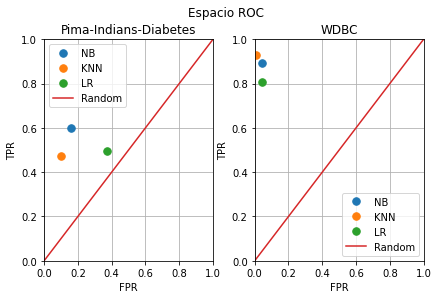

In [13]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Espacio ROC")
fig.tight_layout()
for axis, points, title in zip(ax.flatten(), [roc_points_pima, roc_points_wdbc], ['Pima-Indians-Diabetes', 'WDBC']):
    axis.set_title(title)
    axis.set_xlabel("FPR")
    axis.set_ylabel("TPR")
    axis.set_xlim([0, 1])
    axis.set_ylim([0, 1])
    axis.grid(True)
    for i in range(3):
        axis.plot(points[i][0], points[i][1], '.', ms=15)
    axis.plot([0,1], [0,1])
    axis.legend(['NB', 'KNN', 'LR', 'Random'])

Como se puede apreciar, claramente 'WDBC' es un dataset mucho más fácil de tratar que 'Pima-Indians-Diabetes', ya que todos los clasificadores se encuentran en la parte superior izquierda de la gráfica (lugar ideal). En cambio, en 'Pima-Indians-Diabetes' los clasificadores no tienen tan buen rendimiento. 

Tanto NaiveBayes como KNN se encuentran bastante pegados a la izquierda, indicando que tienen un False Positive Ratio bastante bajo. Aún así, su True Positive Ratio no es de lo mejor, estando ambos alrededor del 0,5. El peor de todos es Regresión Logística. Como se puede apreciar, se encuentra muy cerca de la diagonal que indica el rendimiento de un clasificador aleatorio, confirmando nuestras sospechas del apartado 1. Esto tampoco implica nada excesivamente negativo del clasificador de todas formas, simplemente no es el apropiado para el problema.

# Apartado 4

In [14]:
classifiers_reglog = [classifiers_pima[2], classifiers_wdbc[2]]
confianzas = []
for c, data in zip(classifiers_reglog, [datos_pima, datos_wdbc]):
    confianzas.append(c.validacion_scores(particion, data, seed))
    
roc_curve_points = []
for conf, data in zip(confianzas, [datos_pima, datos_wdbc]):
    conf.sort(key=lambda x: x[1], reverse=True)
    points = [[0, 0]]
    current_point = [0, 0]
    
    unit_arriba = 1/np.count_nonzero(data.datos.to_numpy()[:,-1] == 1)
    unit_derecha = 1/np.count_nonzero(data.datos.to_numpy()[:,-1] == 0)
    for index, score in conf:
        if data.datos.to_numpy()[index, -1] == 1:
            current_point[1] += unit_arriba
        else:
            current_point[0] += unit_derecha
        points.append([current_point[0], current_point[1]])
    
    roc_curve_points.append(points)

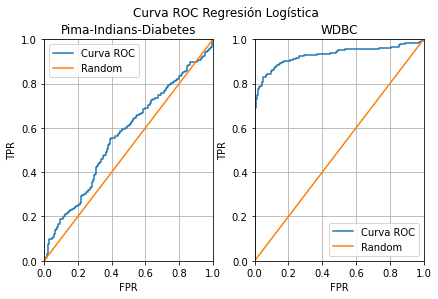

In [15]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Curva ROC Regresión Logística")
fig.tight_layout()
for axis, points, title in zip(ax.flatten(), roc_curve_points, ['Pima-Indians-Diabetes', 'WDBC']):
    axis.set_title(title)
    axis.set_xlabel("FPR")
    axis.set_ylabel("TPR")
    axis.set_xlim([0, 1])
    axis.set_ylim([0, 1])
    axis.grid(True)
    axis.plot([p[0] for p in points], [p[1] for p in points], ms='10')
    axis.plot([0,1], [0,1])
    axis.legend(['Curva ROC', 'Random'])

La representación de la curva ROC muestra unos resultados muy similares a los que esperábamos habiendo observado los anteriores apartados. En el caso de 'Pima-Indian-Diabetes', el clasificador se comporta prácticamente como un clasificador aleatorio. En cambio, para 'WDBC' la curva que se obtiene es bastante buena. Esto es porque inicialmente la curva asciende muy bruscamente para luego tender a un valor constante. Lo que esto implica es que la inmensa mayoría de los datos de Clase 1 están obteniendo un score mayor que los de Clase 2 (como debería ser) haciendo que al ordenar los resultados por score y representando la curva, esta crezca muy bruscamente (todos los datos de Clase 1 con alta score) y luego tienda a moverse en horizontal (datos de Clase 2 con bajo score).